# DA026 Preprocess
01/30/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy


import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'

subj_id = 'DA026'
subj_format = ['edf']
subj_site = ['UCD']


# Make mne_data


### Load and resample data


In [6]:
edf_files = glob(f'{neural_dir}{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


Extracting EDF parameters from /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA026/raw/DA26_SWB.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4764159  =      0.000 ...  2326.250 secs...


In [7]:
mne_data

<RawEDF | DA26_SWB.edf, 110 x 4764160 (2326.2 s), ~3.90 GB, data loaded>

In [9]:
mne_data.ch_names

["P'1",
 "P'2",
 "P'3",
 "P'4",
 "P'5",
 "P'6",
 "P'7",
 "P'8",
 "P'9",
 "P'10",
 "A'1",
 "A'2",
 "A'3",
 "A'4",
 "A'5",
 "A'6",
 "A'7",
 "A'8",
 "A'9",
 "A'10",
 "B'1",
 "B'2",
 "B'3",
 "B'4",
 "B'5",
 "B'6",
 "B'7",
 "B'8",
 "B'9",
 "B'10",
 "G'1",
 "G'2",
 "G'3",
 "G'4",
 "G'5",
 "G'6",
 "G'7",
 "G'8",
 'E2` 1',
 'E2` 2',
 'E2` 3',
 'E2` 4',
 'E2` 5',
 "U'1",
 "U'2",
 "U'3",
 "U'4",
 "U'5",
 "U'6",
 "U'7",
 "U'8",
 "U'9",
 "U'10",
 "I'1",
 "I'2",
 "I'3",
 "I'4",
 "I'5",
 "I'6",
 "I'7",
 "I'8",
 "I'9",
 "I'10",
 "W'1",
 "W'2",
 "W'3",
 "W'4",
 "W'5",
 "W'6",
 "W'7",
 "W'8",
 "W'9",
 "W'10",
 "X'1",
 "X'2",
 "X'3",
 "X'4",
 "X'5",
 "X'6",
 "X'7",
 "X'8",
 "H'1",
 "H'2",
 "H'3",
 "H'4",
 "H'5",
 "H'6",
 "H'7",
 "H'8",
 "F'1",
 "F'2",
 "F'3",
 "F'4",
 "F'5",
 "F'6",
 "F'7",
 "F'8",
 "F'9",
 "F'10",
 "V'1",
 "V'2",
 "V'3",
 "V'4",
 "V'5",
 "V'6",
 "V'7",
 "V'8",
 'DC2',
 'DC3',
 'DC4']

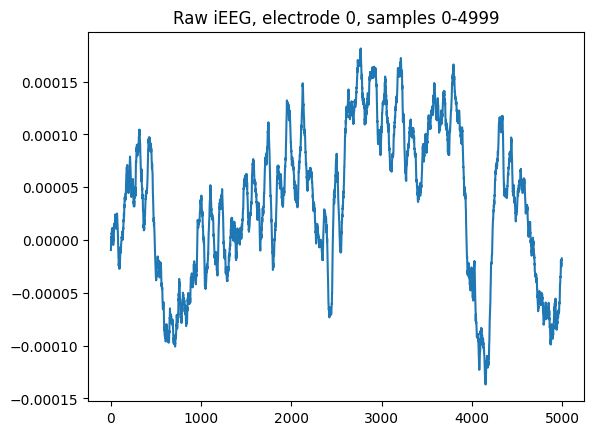

In [8]:
# Sanity check one channel data

plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Resampling data 

In [10]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:   51.9s finished


<RawEDF | DA26_SWB.edf, 110 x 1163125 (2326.2 s), ~976.2 MB, data loaded>

### Photodiode
- examine photodiode 

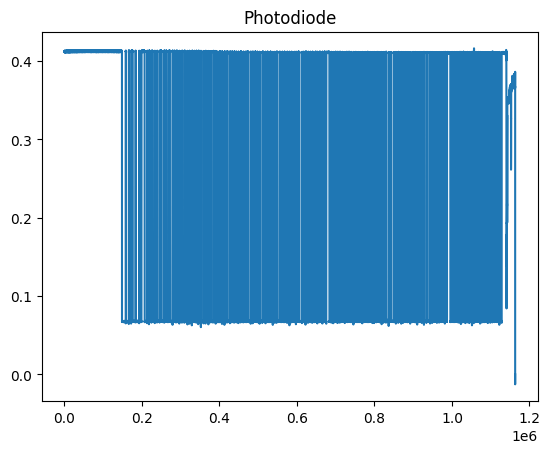

In [11]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC2")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [12]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='DC2', overwrite=True)

Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA026/photodiode.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA026/photodiode.fif
[done]


In [13]:
mne_data.drop_channels(['DC2'])

<RawEDF | DA26_SWB.edf, 109 x 1163125 (2326.2 s), ~967.4 MB, data loaded>

### Notch filter line noise

In [14]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 109 out of 109 | elapsed:    4.6s finished


<RawEDF | DA26_SWB.edf, 109 x 1163125 (2326.2 s), ~967.4 MB, data loaded>

### Anatomical Localization

In [15]:
### Rename channels to be lowercase before anatomical localization
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawEDF | DA26_SWB.edf, 109 x 1163125 (2326.2 s), ~967.4 MB, data loaded>

In [16]:
new_name_dict

{"P'1": "p'1",
 "P'2": "p'2",
 "P'3": "p'3",
 "P'4": "p'4",
 "P'5": "p'5",
 "P'6": "p'6",
 "P'7": "p'7",
 "P'8": "p'8",
 "P'9": "p'9",
 "P'10": "p'10",
 "A'1": "a'1",
 "A'2": "a'2",
 "A'3": "a'3",
 "A'4": "a'4",
 "A'5": "a'5",
 "A'6": "a'6",
 "A'7": "a'7",
 "A'8": "a'8",
 "A'9": "a'9",
 "A'10": "a'10",
 "B'1": "b'1",
 "B'2": "b'2",
 "B'3": "b'3",
 "B'4": "b'4",
 "B'5": "b'5",
 "B'6": "b'6",
 "B'7": "b'7",
 "B'8": "b'8",
 "B'9": "b'9",
 "B'10": "b'10",
 "G'1": "g'1",
 "G'2": "g'2",
 "G'3": "g'3",
 "G'4": "g'4",
 "G'5": "g'5",
 "G'6": "g'6",
 "G'7": "g'7",
 "G'8": "g'8",
 'E2` 1': 'e2`1',
 'E2` 2': 'e2`2',
 'E2` 3': 'e2`3',
 'E2` 4': 'e2`4',
 'E2` 5': 'e2`5',
 "U'1": "u'1",
 "U'2": "u'2",
 "U'3": "u'3",
 "U'4": "u'4",
 "U'5": "u'5",
 "U'6": "u'6",
 "U'7": "u'7",
 "U'8": "u'8",
 "U'9": "u'9",
 "U'10": "u'10",
 "I'1": "i'1",
 "I'2": "i'2",
 "I'3": "i'3",
 "I'4": "i'4",
 "I'5": "i'5",
 "I'6": "i'6",
 "I'7": "i'7",
 "I'8": "i'8",
 "I'9": "i'9",
 "I'10": "i'10",
 "W'1": "w'1",
 "W'2": "w'2",


In [18]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

label BN246label          x          y          z      mni_x      mni_y  \
0     A'1    mAmyg_L -18.516599  15.929303 -20.554255 -19.046408   0.738623   
1    A'10     A21r_L -49.261862  15.130325 -24.146262 -53.055743  -0.979603   
2     A'2       TI_L -22.110201  15.529814 -20.953367 -23.028001   0.200798   
3     A'3    lAmyg_L -25.304514  15.929303 -21.352479 -26.614332   0.467512   
4     A'4    Unknown -28.898116  15.529814 -21.751591 -30.637600  -0.067075   
..    ...        ...        ...        ...        ...        ...        ...   
102   X'4    A40rv_L -47.265416 -26.816012  16.563148 -51.071140 -33.417282   
103   X'5    A40rv_L -50.459729 -25.617546  16.962260 -54.646956 -32.347761   
104   X'6    A40rv_L -54.053331 -24.419079  17.760484 -58.633507 -31.206828   
105   X'7    A40rv_L -56.848355 -23.220612  18.558708 -61.701266 -29.975717   
106   X'8    A40rv_L -60.841247 -22.022145  18.957820 -66.146054 -28.873716   

         mni_z       gm                             NMM             Anat  \
0   -28.174522     Gray        Left Ent entorhinal area    Amygdala (LB)   
1   -32.042539     Gray  Left MTG middle temporal gyrus          Unknown   
2   -28.501798     Gray        Left Ent entorhinal area    Amygdala (LB)   
3   -29.064159  Unknown        Left Ent entorhinal area    Amygdala (LB)   
4   -29.412302    White      Left Cerebral White Matter    Amygdala (LB)   
..         ...      ...                             ...              ...   
102  25.240832    White      Left PO parietal operculum  Area PFcm (IPL)   
103  25.254413     Gray      Left PO parietal operculum  Area PFcm (IPL)   
104  25.656896     Gray    Left SMG supramarginal gyrus  Area PFop (IPL)   
105  26.160723     Gray    Left SMG supramarginal gyrus  Area PFop (IPL)   
106  26.207534     Gray    Left SMG supramarginal gyrus    Area PF (IPL)   

                     AnatMacro    BN246  \
0      L ParaHippocampal Gyrus   L Amyg   
1    L Inferior Temporal Gyrus    L MTG   
2      L ParaHippocampal Gyrus    L PhG   
3      L ParaHippocampal Gyrus   L Amyg   
4      L ParaHippocampal Gyrus  Unknown   
..                         ...      ...   
102      L SupraMarginal Gyrus    L IPL   
103      L SupraMarginal Gyrus    L IPL   
104      L SupraMarginal Gyrus    L IPL   
105      L SupraMarginal Gyrus    L IPL   
106      L SupraMarginal Gyrus    L IPL   

                                     YBA_1 ManualExamination  Notes  
0             Left parahippocampal gyrus A               NaN    NaN  
1    Left inferior middle temporal pole D                NaN    NaN  
2                   Left amygdala inferior               NaN    NaN  
3                   Left amygdala inferior               NaN    NaN  
4                                  Unknown                WM    NaN  
..                                     ...               ...    ...  
102           Left supramarginal gyrus 1 D                WM    NaN  
103           Left supramarginal gyrus 1 D                WM    NaN  
104           Left supramarginal gyrus 1 D               NaN    NaN  
105           Left supramarginal gyrus 1 D                WM    NaN  
106           Left supramarginal gyrus 1 D               OOB    NaN  

[107 rows x 16 columns]

In [19]:
list(elec_locs.label)

["A'1",
 "A'10",
 "A'2",
 "A'3",
 "A'4",
 "A'5",
 "A'6",
 "A'7",
 "A'8",
 "A'9",
 "B'1",
 "B'10",
 "B'2",
 "B'3",
 "B'4",
 "B'5",
 "B'6",
 "B'7",
 "B'8",
 "B'9",
 "E2'1",
 "E2'2",
 "E2'3",
 "E2'4",
 "E2'5",
 "F'1",
 "F'10",
 "F'2",
 "F'3",
 "F'4",
 "F'5",
 "F'6",
 "F'7",
 "F'8",
 "F'9",
 "G'1",
 "G'2",
 "G'3",
 "G'4",
 "G'5",
 "G'6",
 "G'7",
 "G'8",
 "H'1",
 "H'2",
 "H'3",
 "H'4",
 "H'5",
 "H'6",
 "H'7",
 "H'8",
 "I'1",
 "I'10",
 "I'2",
 "I'3",
 "I'4",
 "I'5",
 "I'6",
 "I'7",
 "I'8",
 "I'9",
 "P'1",
 "P'10",
 "P'2",
 "P'3",
 "P'4",
 "P'5",
 "P'6",
 "P'7",
 "P'8",
 "P'9",
 "U'1",
 "U'10",
 "U'2",
 "U'3",
 "U'4",
 "U'5",
 "U'6",
 "U'7",
 "U'8",
 "U'9",
 "V'1",
 "V'2",
 "V'3",
 "V'4",
 "V'5",
 "V'6",
 "V'7",
 "V'8",
 "W'1",
 "W'10",
 "W'2",
 "W'3",
 "W'4",
 "W'5",
 "W'6",
 "W'7",
 "W'8",
 "W'9",
 "X'1",
 "X'2",
 "X'3",
 "X'4",
 "X'5",
 "X'6",
 "X'7",
 "X'8"]

In [20]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['e2`1', 'e2`2', 'e2`3', 'e2`4', 'e2`5', 'dc3', 'dc4']


In [21]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


In [22]:
unmatched_seeg #make sure there are no unmatched names


[]

In [23]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [24]:
new_name_dict #make sure this passes the eye test 


{"p'1": "p'1",
 "p'2": "p'2",
 "p'3": "p'3",
 "p'4": "p'4",
 "p'5": "p'5",
 "p'6": "p'6",
 "p'7": "p'7",
 "p'8": "p'8",
 "p'9": "p'9",
 "p'10": "p'10",
 "a'1": "a'1",
 "a'2": "a'2",
 "a'3": "a'3",
 "a'4": "a'4",
 "a'5": "a'5",
 "a'6": "a'6",
 "a'7": "a'7",
 "a'8": "a'8",
 "a'9": "a'9",
 "a'10": "a'10",
 "b'1": "b'1",
 "b'2": "b'2",
 "b'3": "b'3",
 "b'4": "b'4",
 "b'5": "b'5",
 "b'6": "b'6",
 "b'7": "b'7",
 "b'8": "b'8",
 "b'9": "b'9",
 "b'10": "b'10",
 "g'1": "g'1",
 "g'2": "g'2",
 "g'3": "g'3",
 "g'4": "g'4",
 "g'5": "g'5",
 "g'6": "g'6",
 "g'7": "g'7",
 "g'8": "g'8",
 'e2`1': 'e2`1',
 'e2`2': 'e2`2',
 'e2`3': 'e2`3',
 'e2`4': 'e2`4',
 'e2`5': 'e2`5',
 "u'1": "u'1",
 "u'2": "u'2",
 "u'3": "u'3",
 "u'4": "u'4",
 "u'5": "u'5",
 "u'6": "u'6",
 "u'7": "u'7",
 "u'8": "u'8",
 "u'9": "u'9",
 "u'10": "u'10",
 "i'1": "i'1",
 "i'2": "i'2",
 "i'3": "i'3",
 "i'4": "i'4",
 "i'5": "i'5",
 "i'6": "i'6",
 "i'7": "i'7",
 "i'8": "i'8",
 "i'9": "i'9",
 "i'10": "i'10",
 "w'1": "w'1",
 "w'2": "w'2",
 "w'3

In [25]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawEDF | DA26_SWB.edf, 109 x 1163125 (2326.2 s), ~967.4 MB, data loaded>

In [28]:
#manually dropping channels bc of stupid naming scheme
drop_chans = ['dc3','dc4']
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs 

<RawEDF | DA26_SWB.edf, 107 x 1163125 (2326.2 s), ~949.6 MB, data loaded>

In [29]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in mne_data.ch_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawEDF | DA26_SWB.edf, 107 x 1163125 (2326.2 s), ~949.6 MB, data loaded>

In [30]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | DA26_SWB.edf, 107 x 1163125 (2326.2 s), ~949.7 MB, data loaded>

## Signal Cleaning 
Methods:
- Use manual bad channel detection for **bipolar** referencing
    - bipolar referencing completely ignores channels labeled as 'bad' so do not remove unless absolutely necessary
    - remove ch if there is massive artifact in a channel not in the rest of probe 
    - if entire probe shows same artifact try to keep
- Remove additional channels as needed
- This process is iterative depending on how TFRs look. 

In [31]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)
# probe_names

In [32]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [33]:
probe_ch_counts

{"a'": 10,
 "b'": 10,
 "e'": 5,
 "f'": 10,
 "g'": 8,
 "h'": 8,
 "i'": 10,
 "p'": 10,
 "u'": 10,
 "v'": 8,
 "w'": 10,
 "x'": 8}

### Compare auto detection result to actual lfp data - if trusted save auto result as mne bads
- often inaccurate - verify that all included channels make sense and all channels that should be included are
- take out any crazy noise, especially if it's only in one channel on probe (won't be cancelled out)

In [34]:
# mne_data.info['bads'] = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #this is likely inaccurate - just use to get an idea 
lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)

["p'2", "p'3", "u'10", "u'7", "u'8"]

<IPython.core.display.Javascript object>


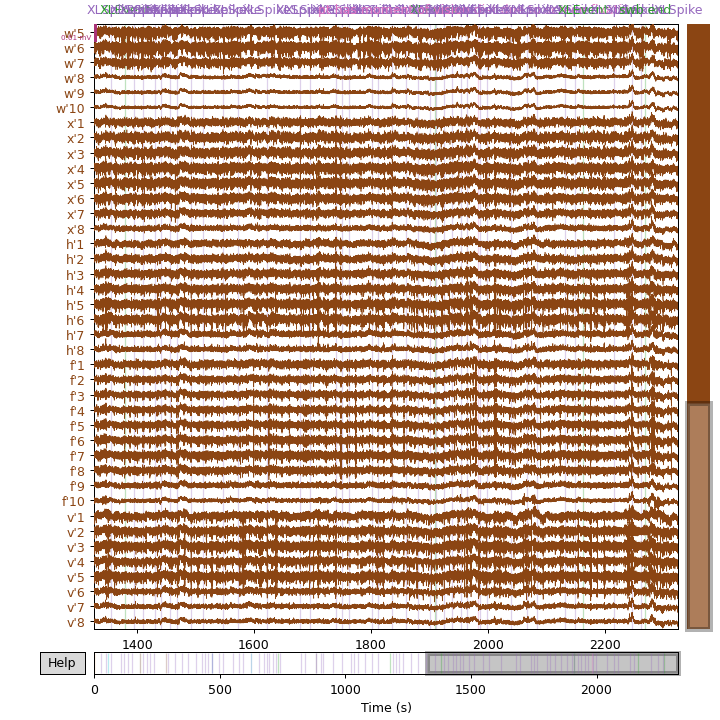

In [38]:
 %matplotlib notebook
fig = mne_data.plot(start=0, duration=1000, n_channels=40, scalings=mne_data._data.max()/5)


In [39]:
mne_data.info['bads']

[]

In [40]:
mne_data.info #sanity check that bads info saved

<Info | 9 non-empty values
 bads: []
 ch_names: p'1, p'2, p'3, p'4, p'5, p'6, p'7, p'8, p'9, p'10, a'1, a'2, ...
 chs: 107 sEEG
 custom_ref_applied: False
 dig: 102 items (102 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 250.0 Hz
 meas_date: 2023-09-20 14:28:19 UTC
 nchan: 107
 projs: []
 sfreq: 500.0 Hz
>

# Bipolar Re-referencing 
- plot lfp bp data
- plot psd bp data
- save bp reref data 


In [41]:
#run if only re-ref
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

### Bipolar Re-ref

In [42]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=19, n_times=1163125
    Range : 0 ... 1163124 =      0.000 ...  2326.248 secs
Ready.
Added the following bipolar channels:
a'1-a'2, a'8-a'9, a'9-a'10, b'2-b'3, b'3-b'4, b'4-b'5, b'8-b'9, b'9-b'10, g'1-g'2, g'6-g'7, h'6-h'7, p'5-p'6, p'6-p'7, p'7-p'8, v'5-v'6, v'6-v'7, w'3-w'4, x'1-x'2, x'2-x'3


In [43]:
mne_data_bp_reref

<RawEDF | DA26_SWB.edf, 19 x 1163125 (2326.2 s), ~168.7 MB, data loaded>

In [44]:
mne_data_bp_reref.ch_names

["a'1-a'2",
 "a'8-a'9",
 "a'9-a'10",
 "b'2-b'3",
 "b'3-b'4",
 "b'4-b'5",
 "b'8-b'9",
 "b'9-b'10",
 "g'1-g'2",
 "g'6-g'7",
 "h'6-h'7",
 "p'5-p'6",
 "p'6-p'7",
 "p'7-p'8",
 "v'5-v'6",
 "v'6-v'7",
 "w'3-w'4",
 "x'1-x'2",
 "x'2-x'3"]

#### Examine bp ref data 
- examine lfp plot to see if major artifacts are still present
- examine psd to see if there are any major peaks in channels

<IPython.core.display.Javascript object>


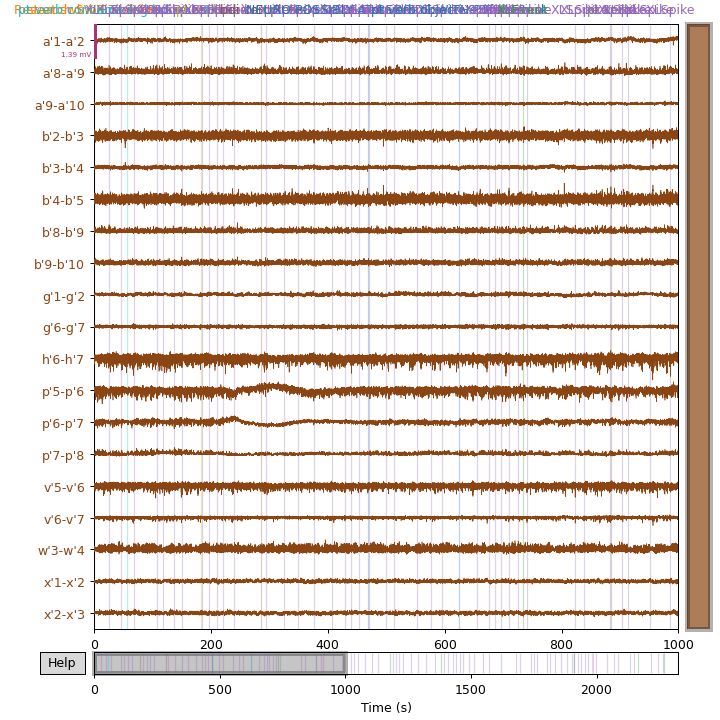

In [45]:
 %matplotlib notebook
fig = mne_data_bp_reref.plot(start=0, duration=1000, n_channels=40, scalings=mne_data_bp_reref._data.max())


Effective window size : 0.512 (s)


<IPython.core.display.Javascript object>


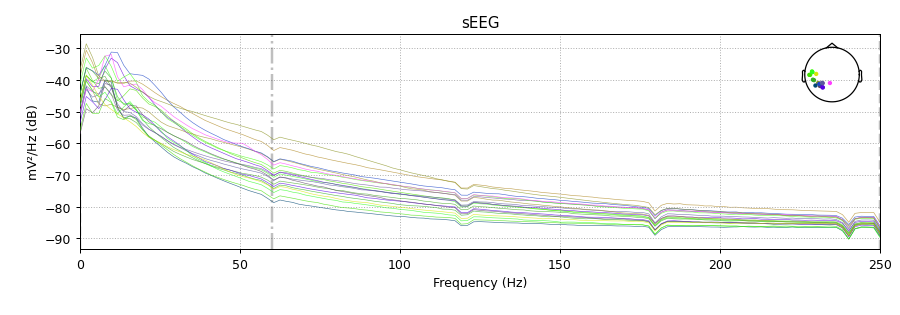

<IPython.core.display.Javascript object>


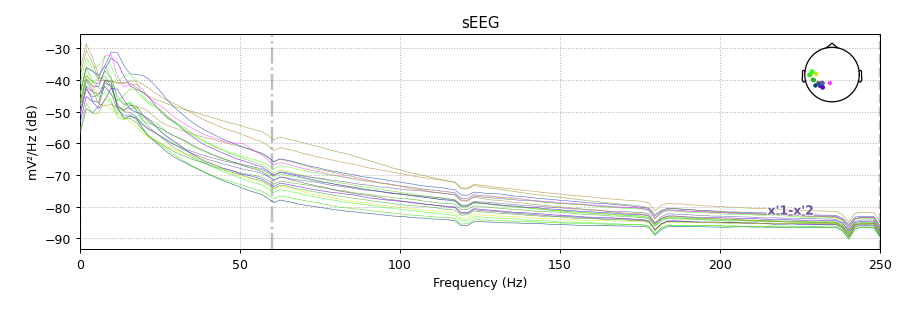

In [46]:
mne_data_bp_reref.compute_psd().plot()

In [47]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA026/bp_ref_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA026/bp_ref_ieeg.fif
[done]


## Save mne_data

In [48]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA026/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA026/raw_ieeg.fif
[done]


# Epoching + TFRs
- Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated
- Align photodiode to behavior 
- Epoch data (and mark bad epochs)
- Baseline data
- Visualize TFRs 

In [49]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref

### Photodiode Alignment

In [50]:
#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
# behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA026/photodiode.fif...
Isotrak not found
    Range : 0 ... 1163124 =      0.000 ...  2326.248 secs
Ready.
Reading 0 ... 1163124  =      0.000 ...  2326.248 secs...


In [51]:
photodiode_data

<Raw | photodiode.fif, 1 x 1163125 (2326.2 s), ~8.9 MB, data loaded>

<IPython.core.display.Javascript object>


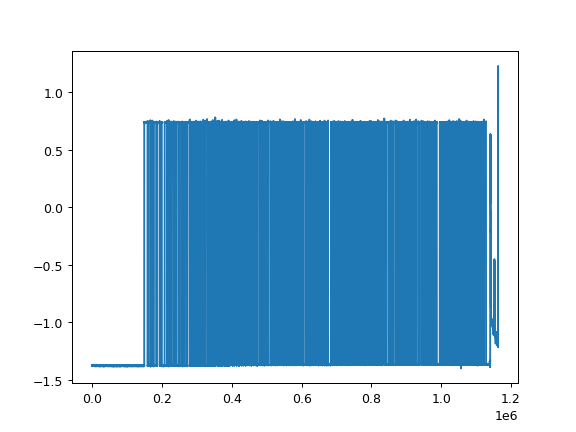

In [53]:
plt.plot(scipy.stats.zscore(-photodiode_data._data[0,:]))

In [54]:
temp_diode = photodiode_data.copy()
temp_data = -temp_diode._data[0,:]
temp_diode._data = temp_data
# temp_data = temp_diode._data[0,:]
# temp_data[0:450000] = 0
# temp_data[570000:] = 0
# temp_data[temp_data>4000] = 0
# temp_data = np.abs(temp_data-np.nanmax(temp_data)) #consider resaving photodiode 
# temp_data = np.abs(temp_diode._data[0, :])
# temp_data[0:1250000] = 0


In [76]:
### Photodiode alignment
smoothSize=11
windSize=15
height=0.5

# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            temp_diode, #
                                            smoothSize, windSize, height)

10 blocks
..........

found matches for 120 of 158 pulses


In [77]:
print(slope, offset,smoothSize,windSize,height)

1.0000053443186248 -149.1950330834411 11 15 0.5


In [78]:
[(x*slope + offset) for x in beh_ts]

[414.48419678093774,
 429.01740801328845,
 440.9121709495806,
 455.8666774173821,
 467.99176030781746,
 480.01491848978253,
 502.7638624670842,
 516.710029211086,
 527.4296750707451,
 545.1773601065277,
 560.0943992440986,
 570.5652346855557,
 583.1610872867917,
 595.0799109339479,
 608.8103685729809,
 623.4924305803419,
 636.8874568519038,
 646.4988023215083,
 662.4407786021505,
 673.1188491635609,
 683.7612491835661,
 695.5100050068436,
 706.1027411110928,
 719.696054403416,
 732.6260696287903,
 745.3444898611822,
 756.8045369485293,
 773.1919388080531,
 782.2867384584085,
 792.7696086928404,
 806.4604175293695,
 815.6670498224094,
 828.2135085039378,
 842.8779436253686,
 856.3462241640209,
 866.9824647919852,
 879.4944001586164,
 888.5333314454101,
 898.7826192443063,
 913.6951967911157,
 925.314113863169,
 934.4515421716401,
 949.3963943173608,
 963.5263194947838,
 974.1204782838252,
 987.0128794054724,
 997.8221670297978,
 1009.2833159470226,
 1027.7281755339177,
 1039.83844516370

In [214]:
# del epochs_all_baseline, power_epochs, plot_data

## Epoch Data
- Epoch neural data into trial epochs 
- Add behavioral data to epochs metadata
- Save epochs
- Baseline + decompose data into TFRs
- Plot + save TFRs (examine quality)

### Epoch data

In [79]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [80]:
# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [81]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [82]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values, 
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, IED_args=IED_args) #1.0 buf unsaved

    epochs_all_evs[event] = ev_epochs
    

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA026/bp_ref_ieeg.fif...
    Range : 0 ... 1163124 =      0.000 ...  2326.248 secs
Ready.
Reading 0 ... 1163124  =      0.000 ...  2326.248 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 sec)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    1.6s finished


Used Annotations descriptions: ['TrialOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 1501 original time points ...
0 bad epochs dropped
Adding metadata with 19 columns
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA026/bp_ref_ieeg.fif...
    Range : 0 ... 1163124 =      0.000 ...  2326.248 secs
Ready.
Reading 0 ... 1163124  =      0.000 ...  2326.248 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    2.3s finished


Used Annotations descriptions: ['DecisionOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 3501 original time points ...
0 bad epochs dropped
Adding metadata with 19 columns


In [84]:
epochs_all_evs 


{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~32.7 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1 - 6 sec, baseline off, ~76.2 MB, data loaded, with metadata,
  'DecisionOnset': 150>}

### Add behavioral data to metadata 

In [85]:
behav_df.columns

Index(['Round', 'Trial Num', 'TrialType', 'TrialOnset', 'ChoiceOnset',
       'DecisionOnset', 'FeedbackOnset', 'RT', 'SafeBet', 'LowBet', 'HighBet',
       'HighBetPos', 'GamblePos', 'ChoicePos', 'GambleChoice', 'Outcome',
       'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
       'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
       'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE',
       'nRPE', 'util_safe_mle', 'util_gamble_mle', 'wSafe_mle', 'wHigh_mle',
       'wLow_mle', 'p_safe_mle', 'p_gamble_mle', 'util_safe_emmap',
       'util_gamble_emmap', 'wSafe_emmap', 'wHigh_emmap', 'wLow_emmap',
       'p_safe_emmap', 'p_gamble_emmap', 'util_tCPE_mle', 'util_dCPE_mle',
       'util_tCF_mle', 'util_dCF_mle', 'util_tRegret_mle', 'util_dRegret_mle',
       'util_tRelief_mle', 'util_dRelief_mle', 'util_RPE_mle', 'util_pRPE_mle',
       'util_nRPE_mle', 'util_tCPE_emmap', 'util_dCPE_emmap', 'util_tCF_emmap',
       'util_dCF_emmap', 'util_tRegr

In [86]:
behav_params = ['TrialType','SafeBet', 'LowBet', 'HighBet','GambleChoice', 'Outcome',
       'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
       'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
       'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE',
       'nRPE', 'util_safe_mle', 'util_gamble_mle', 'wSafe_mle', 'wHigh_mle',
       'wLow_mle', 'p_safe_mle', 'p_gamble_mle', 'util_safe_emmap',
       'util_gamble_emmap', 'wSafe_emmap', 'wHigh_emmap', 'wLow_emmap',
       'p_safe_emmap', 'p_gamble_emmap', 'util_tCPE_mle', 'util_dCPE_mle',
       'util_tCF_mle', 'util_dCF_mle', 'util_tRegret_mle', 'util_dRegret_mle',
       'util_tRelief_mle', 'util_dRelief_mle', 'util_RPE_mle', 'util_pRPE_mle',
       'util_nRPE_mle', 'util_tCPE_emmap', 'util_dCPE_emmap', 'util_tCF_emmap',
       'util_dCF_emmap', 'util_tRegret_emmap', 'util_dRegret_emmap',
       'util_tRelief_emmap', 'util_dRelief_emmap', 'util_RPE_emmap',
       'util_pRPE_emmap', 'util_nRPE_emmap']

In [87]:
for event in evs.keys():

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

Replacing existing metadata with 77 columns
Replacing existing metadata with 77 columns


In [88]:
epochs_all_evs[event].metadata

a'1-a'2     a'8-a'9 a'9-a'10 b'2-b'3 b'3-b'4 b'4-b'5 b'8-b'9  \
0       NaN         NaN      NaN     NaN     NaN     NaN     NaN   
1       NaN         NaN      NaN     NaN     NaN     NaN     NaN   
2       NaN         NaN      NaN     NaN     NaN     NaN     NaN   
3       NaN         NaN      NaN     NaN     NaN     NaN     NaN   
4       NaN         NaN      NaN     NaN     NaN   noise     NaN   
..      ...         ...      ...     ...     ...     ...     ...   
145     NaN         NaN      NaN     NaN     NaN     NaN     NaN   
146     NaN         NaN      NaN     NaN     NaN     NaN     NaN   
147     NaN         NaN      NaN     NaN     NaN     NaN     NaN   
148     NaN  [2241.946]      NaN     NaN     NaN     NaN     NaN   
149     NaN  [2254.576]      NaN     NaN     NaN     NaN     NaN   

                           b'9-b'10 g'1-g'2 g'6-g'7  ... util_dCPE_emmap  \
0                               NaN     NaN     NaN  ...        1.015498   
1                               NaN     NaN     NaN  ...        0.000000   
2                               NaN     NaN     NaN  ...       -0.565058   
3                         [462.552]     NaN     NaN  ...        1.117162   
4                               NaN     NaN     NaN  ...        0.358692   
..                              ...     ...     ...  ...             ...   
145                             NaN     NaN     NaN  ...       -0.187282   
146                             NaN     NaN     NaN  ...        0.739459   
147                             NaN     NaN     NaN  ...        0.182585   
148  [2238.952, 2241.528, 2241.796]     NaN     NaN  ...       -0.193180   
149             [2251.668, 2252.05]     NaN     NaN  ...        0.635359   

    util_tCF_emmap util_dCF_emmap util_tRegret_emmap util_dRegret_emmap  \
0        -1.015498      -1.015498           0.000000           0.000000   
1         0.000000       0.000000           0.000000           0.000000   
2         0.565058       0.565058          -0.565058          -0.565058   
3        -1.304223      -1.117162           0.000000           0.000000   
4        -1.015498       0.000000           0.000000           0.000000   
..             ...            ...                ...                ...   
145       0.000000       0.581922           0.000000           0.000000   
146       0.000000       0.000000           0.000000           0.000000   
147       0.556874       0.556874           0.182585           0.182585   
148       0.193180       0.193180          -0.193180          -0.193180   
149      -1.219748       0.000000           0.000000           0.000000   

    util_tRelief_emmap util_dRelief_emmap util_RPE_emmap util_pRPE_emmap  \
0             1.015498           1.015498       0.000000        0.000000   
1             0.000000           0.000000       0.000000        0.000000   
2             0.000000           0.000000       0.000000        0.000000   
3             1.304223           1.117162       1.304223        1.304223   
4             1.374190           0.358692       1.015498        1.015498   
..                 ...                ...            ...             ...   
145           0.394640          -0.187282       0.000000        0.000000   
146           0.739459           0.739459       0.000000        0.000000   
147           0.000000           0.000000       0.000000        0.000000   
148           0.000000           0.000000       0.000000        0.000000   
149           1.855106           0.635359       1.219748        1.219748   

    util_nRPE_emmap  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0  
..              ...  
145             0.0  
146             0.0  
147             0.0  
148             0.0  
149             0.0  

[150 rows x 77 columns]

### Save raw epoched data 

In [89]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/bp_epoch_{event}.fif', overwrite=True)

### Baseline + Decompose into TFRs

In [90]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict
analysis_evs = ['DecisionOnset']
baseline_ev = 'TrialOnset'
evs = {'TrialOnset': [-1.0, 0], #maybe increase to full second to take cycles up to 4
       #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [91]:
# Set some spectrogram parameters 
freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = 3
sr = 500.0 
buf = 1.0
buf_ix = int(buf*sr)

In [92]:
epochs_all_baseline = {} #removed unecessary 'decisiononset' empty key

In [93]:
#baseline epoch - 
event = 'TrialOnset'
epochs = epochs_all_evs[event]

good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

for ch_ix in np.arange(epochs._data.shape[1]): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0]
    good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
    ch_data = np.delete(ch_data, bad_epochs, axis=0)
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=1)

    pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)
temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])

epochs_all_baseline[event] = temp_pow


Not setting metadata


In [94]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 19, ~326.9 MB>}

In [95]:
power_epochs = {}

In [96]:
event = 'DecisionOnset'

epochs = epochs_all_evs[event]

# Let's make sure we only do this for good channels
good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

for ch_ix in np.arange(epochs._data.shape[1]): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0] 
    good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
    ch_data = np.delete(ch_data, bad_epochs, axis=0) #this is where bad epochs for ch are deleted!!
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=1)

    pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)

temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])


baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                                                  baseline_mne=epochs_all_baseline['TrialOnset'], 
                                                  mode='zscore', 
                                                  trialwise=False, ## make sure this is FALSE!
                                                  baseline_only=True)


zpow = mne.time_frequency.EpochsTFR(epochs.info, baseline_corrected_power, 
                                temp_pow.times, freqs)

zpow.metadata = epochs_all_evs[event].metadata

power_epochs[event] = zpow



Not setting metadata
Not setting metadata
Adding metadata with 77 columns


In [97]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [0.000000, 5.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 19, ~1.59 GB>

In [98]:
#conda install -c conda-forge h5io must install to save tfr data
power_epochs['DecisionOnset'].save(f'{neural_dir}{subj_id}/bp_pow_epochs-tfr.h5', overwrite=True)


## Plot TFRs

In [99]:
####add directory for TFRs
tfr_dir = f'{base_dir}ephys_analysis/figs/TFRs/{subj_id}/all_trials/'
os.makedirs(tfr_dir,exist_ok = True) #added so you don't have to manually make subject folders in clean_data
date = datetime.date.today().strftime('%m%d%Y')

print(date)
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)

01312024


In [100]:
#to reload for more cleaning if necessary
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif',preload=True)

-149.1950330834411


<IPython.core.display.Javascript object>


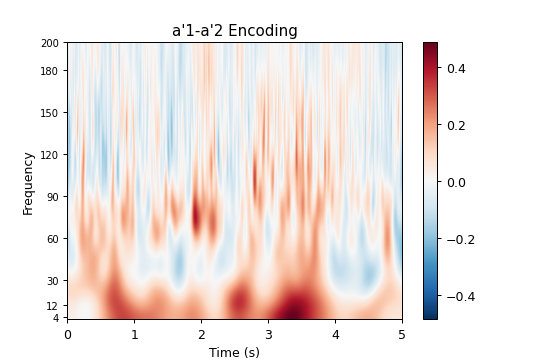

<IPython.core.display.Javascript object>


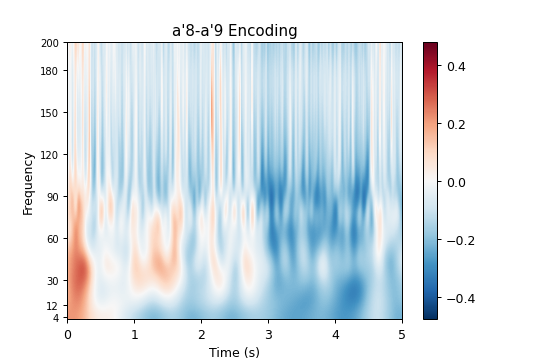

<IPython.core.display.Javascript object>


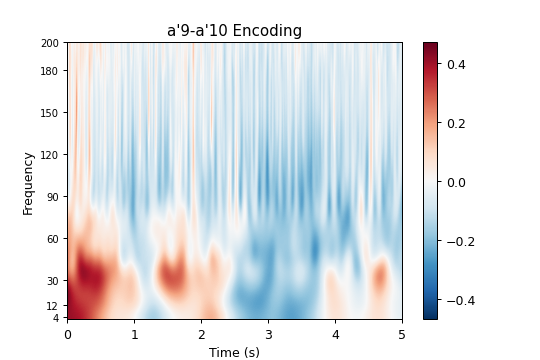

<IPython.core.display.Javascript object>


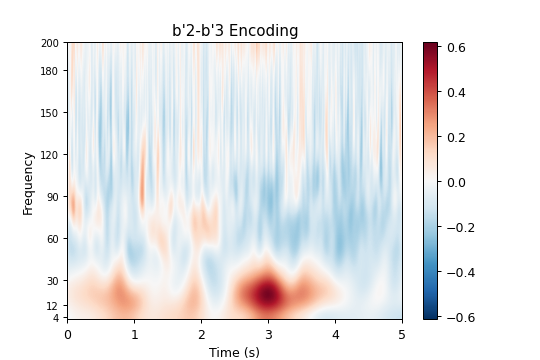

<IPython.core.display.Javascript object>


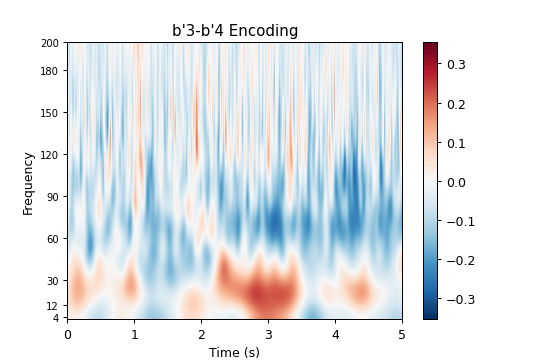

<IPython.core.display.Javascript object>


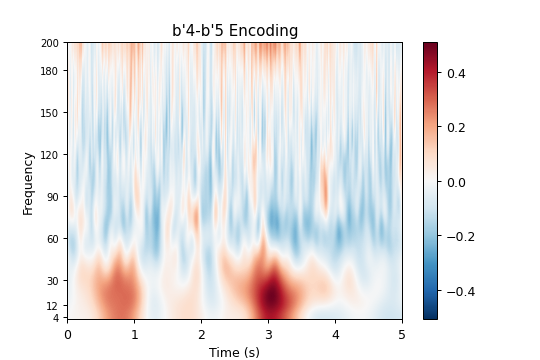

<IPython.core.display.Javascript object>


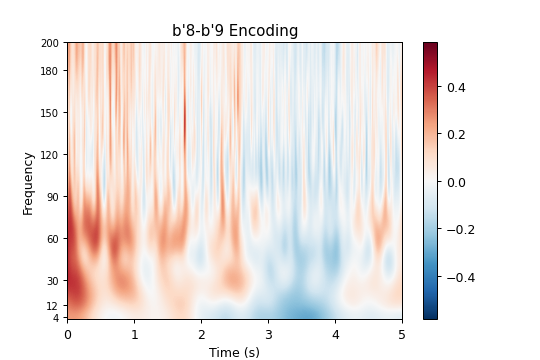

<IPython.core.display.Javascript object>


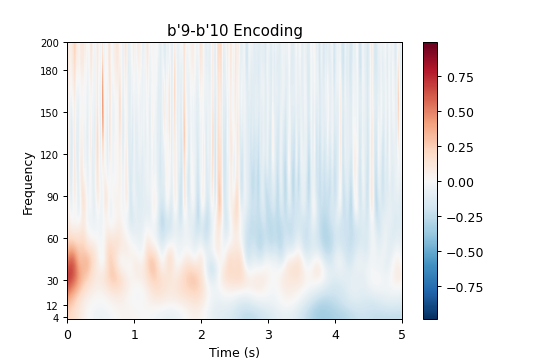

<IPython.core.display.Javascript object>


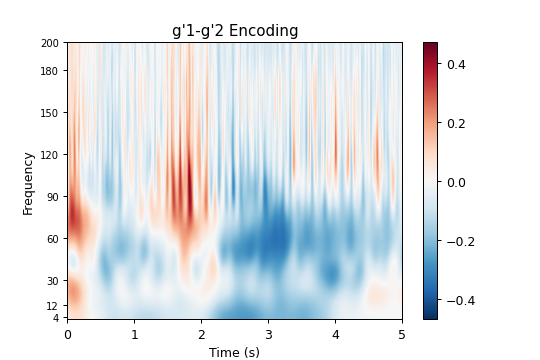

<IPython.core.display.Javascript object>


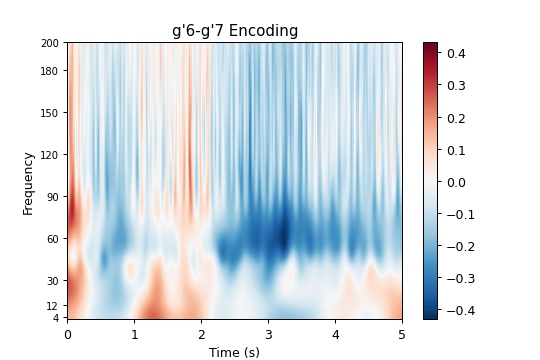

<IPython.core.display.Javascript object>


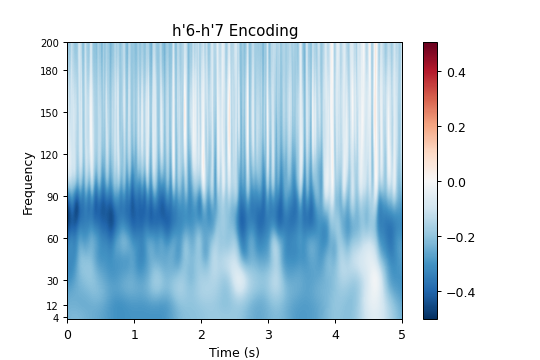

<IPython.core.display.Javascript object>


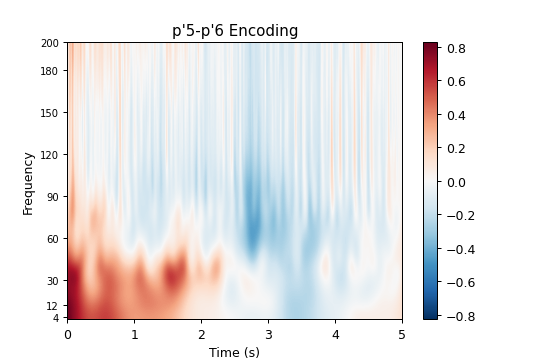

<IPython.core.display.Javascript object>


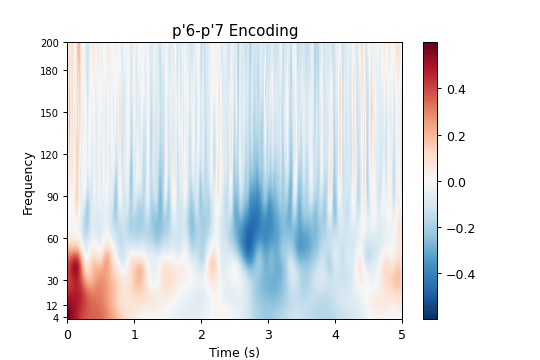

<IPython.core.display.Javascript object>


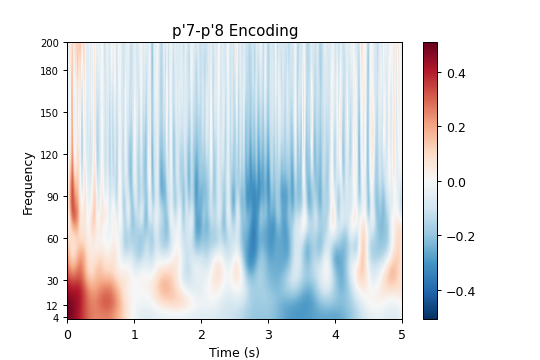

<IPython.core.display.Javascript object>


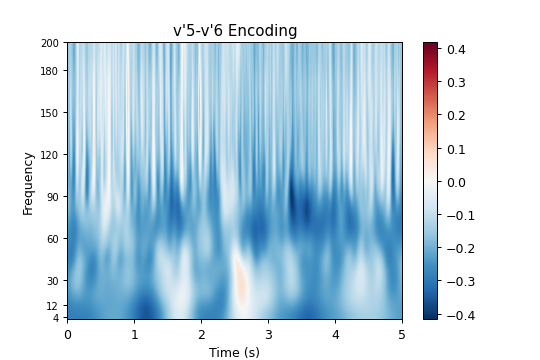

<IPython.core.display.Javascript object>


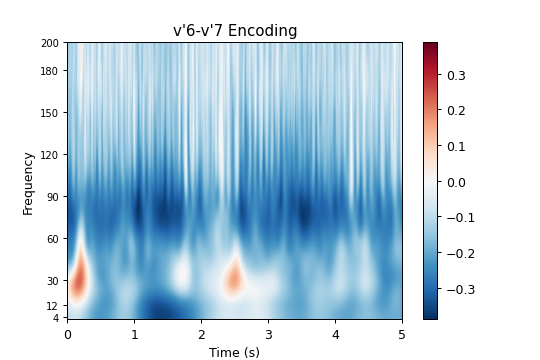

<IPython.core.display.Javascript object>


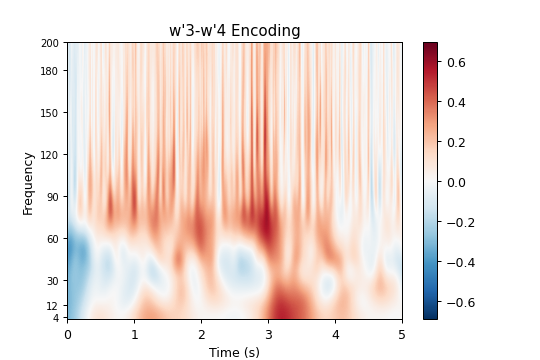

<IPython.core.display.Javascript object>


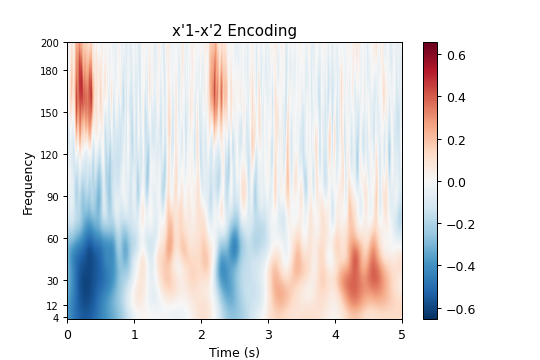

<IPython.core.display.Javascript object>


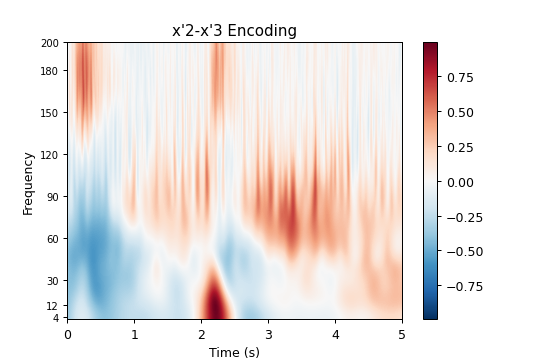

In [101]:
event = 'DecisionOnset'
yticks = [4, 12, 30, 60, 90, 120, 150, 180, 200]
good_ch = [x for x in power_epochs[event].ch_names if '-' in x]
save_path = tfr_dir

print(offset)


for ch in good_ch:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    times = power_epochs[event].times
    plot_data = np.nanmean(np.nanmean(power_epochs[event].copy().pick_channels([ch]).data, axis=0), axis=0)

    im = ax.imshow(plot_data,
            extent=[times[0], times[-1], freqs[0], freqs[-1]], interpolation='Bicubic',
            aspect='auto', origin='lower', cmap='RdBu_r',vmin = -np.nanmax(np.abs(plot_data)), vmax = np.nanmax(np.abs(plot_data)))
    ax.set(yticks=yticks, xlabel='Time (s)', ylabel='Frequency',title=f'{ch} Encoding')
    ax.yaxis.set_tick_params(labelsize=8)
    fig.colorbar(im, ax=ax)
    plt.savefig(f'{save_path}/{ch}_{date}_bp_ref.png', format='png', metadata=None,
    bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto',
    backend=None)
#     plt.close()
